# Running a model and loading the simulation it produces
Very simple example with the stationary dynamic system defined in ```test_lake.yaml```. Basically it represents a stationary reservoir whose discretized mass balance equation is modelled as in the left side of the following table. On the right side, you find the pseudocode in the ```test_lake.yaml```.

<table>
<tr>
<th>Equations</th>
<th>YAML</th>
</tr>
<tr>
<td>
$$\begin{aligned}
h_{t+1} &= h_t + \Delta_t * \left(a_{t+1} - r_{t+1} \right) \\
r_{t+1} &= \begin{cases}
h_t & u_t > h_t \\
u_t & h_t - 100 < u_t \leq h_t \\
h_t - 100 & u_t \leq h_t - 100
\end{cases} \\
u_t &= m\left(h_t; \theta\right) \\
a_{t+1} &= 40
\end{aligned}$$
</td>
<td>
```
functions:
  - "h[t+1] = h[t] + 1 * (a[t+1] - r[t+1])"
  - "r[t+1] = max( max( h[t] - 100, 0 ), min( h[t], u[t] ) )"
  # - "u[t] = RBF( h[t], architecture=3, uniformizers=[(0,155), (0,155)] )"
  - "u[t] = alfa * h[t]"
  - "a[t+1] = 40"
  - "h[0] = 100"
```
</td>
</tr>
</table>

and the initial condition is given by $h_0 = 100$. Note that the control of this reservoir is demanded to a feedback 
policy ($u_t = m\left(h_t; \theta\right)$) that is identified by a class $m(\cdot)$ of functions and a set of parameters $\theta$.

The system is operated to achieve certain objectives over the entire operational horizon simulated, namely:
* limit flooding along lake shores,
* supply a certain amount of water to downstream irrigation districts,
* supply water to an hydropower plant that has to meet a certain demand,
* limit flooding along the downstream water body.

These objectives are formulated as the daily mean of the following indicators:

<table>
<tr>
<th>Equations</th>
<th>YAML</th>
</tr>
<tr>
<td>
$$\begin{aligned}
h^\text{excess}_{t+1} &= \max\left( h_t - 50, 0 \right) \\
\text{deficit}^{irr}_{t+1} &= \max\left( 50 - r_{t+1}, 0 \right) \\
\text{deficit}^{HP}_{t+1} &= \max\left( 4.36 - HP_{t+1}, 0 \right) \\
HP_{t+1} &= \frac{1 * 9.81 * 1000 * h_t * \max\left( r_{t+1} - 0, 0 \right)}{3600 * 1000} \\
r^\text{excess}_{t+1} &= \max\left( r_{t+1} - 30, 0 \right)
\end{aligned}$$
</td>
<td>
```
functions:
  # indicators
  - "h_excess[t+1] = max( h[t] - 50, 0 )"
  - "irr_deficit[t+1] = max( 50 - r[t+1], 0 )"
  - "hyd_deficit[t+1] = max( 4.36 - HP[t+1], 0 )"
  - "HP[t+1] = 1 * 9.81 * 1000 / 3600000 * h[t] * max( r[t+1] - 0, 0 )"
  - "r_excess[t+1] = max( r[t+1] - 30, 0 )"
  # overall objectives
  - "mean_daily_h_excess = mean( h_excess[1:100] )"
  - "mean_daily_irr_deficit = mean( irr_deficit[2:101] )"
  - "mean_daily_hyd_deficit = mean( hyd_deficit[2:101] )"
  - "mean_daily_r_excess = mean( r_excess[2:101] )"
```
</td>
</tr>
</table>

## Running the actual model

In [24]:
from subprocess import Popen, PIPE, STDOUT
p = Popen(["../pydmmt/pydmmt.py", "test_lake.yml"], stdin=PIPE, stdout=PIPE, stderr=STDOUT)
output = p.communicate(".3".encode('utf-8'))[0]
# trim the '\n' newline char
print(output[:-1].decode('utf-8'))

82.2109988777 10.2356902357 0.0 9.76430976431


Now load results and cleanup the simulation file

In [25]:
from pathlib import Path
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
simfile = Path("lake_simulation.log")
# read sim_data_file and remove the character "#" from the first column
with simfile.open() as f:
    the_sim = pd.read_csv(f)
    the_sim = the_sim.rename(columns={'# t':'t'})
f.close()
os.remove(str(simfile))
print(the_sim)

       t        h[t]  a[t+1]       u[t]     r[t+1]
0      0  100.000000     NaN  30.000000        NaN
1      1  110.000000    40.0  33.000000  30.000000
2      2  117.000000    40.0  35.100000  33.000000
3      3  121.900000    40.0  36.570000  35.100000
4      4  125.330000    40.0  37.599000  36.570000
5      5  127.731000    40.0  38.319300  37.599000
6      6  129.411700    40.0  38.823510  38.319300
7      7  130.588190    40.0  39.176457  38.823510
8      8  131.411733    40.0  39.423520  39.176457
9      9  131.988213    40.0  39.596464  39.423520
10    10  132.391749    40.0  39.717525  39.596464
11    11  132.674224    40.0  39.802267  39.717525
12    12  132.871957    40.0  39.861587  39.802267
13    13  133.010370    40.0  39.903111  39.861587
14    14  133.107259    40.0  39.932178  39.903111
15    15  133.175081    40.0  39.952524  39.932178
16    16  133.222557    40.0  39.966767  39.952524
17    17  133.255790    40.0  39.976737  39.966767
18    18  133.279053    40.0  3

## Plotting

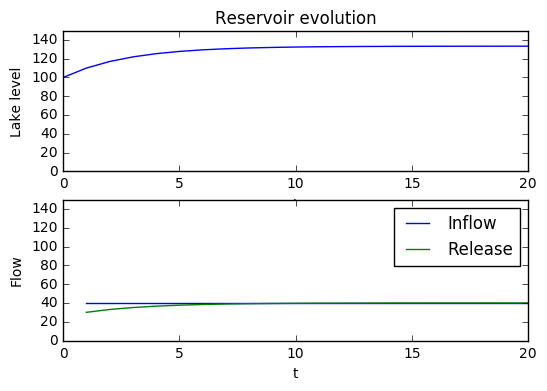

In [27]:
level = pd.Series(the_sim["h[t]"], index=the_sim["t"])
inflow = pd.Series(the_sim["a[t+1]"], index=the_sim["t"])
release = pd.Series(the_sim["r[t+1]"], index=the_sim["t"])

plt.figure()
plt.subplot(211)
level.plot()
plt.axis([0, 20, 0, 150])
plt.ylabel("Lake level")
plt.title("Reservoir evolution")

plt.subplot(212)
inflow.plot()
release.plot()
plt.axis([0, 20, 0, 150])
plt.ylabel("Flow")
plt.legend(["Inflow", "Release"])

plt.show()